In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Extended correlation violin plots for experiment 1 with synthetic data.

In [2]:
from IPython import display
import pandas as pd
import numpy as np
import scipy
import scipy.stats

from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as mpatches
from tensorflow import keras

from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import pickle
from timeit import default_timer as timer

In [3]:
tfd = tfp.distributions
tfb = tfp.bijectors

tanh = tfb.Tanh()
tanh_inv = tfb.Invert(tanh)
cor_bij = tfb.Chain([tanh,tfb.Scale(scale=0.5)])
cor_bij_inv = tfb.Invert(cor_bij)

a1=300 #Number of genes
a2=[5,10,25,50,100,200,400,800,1600] #Number of cells
Folder = '/content/drive/MyDrive/'

In [4]:
#Aggregate posterior correlations samples from different experiments.
lb_cor_tick=[]
lb_cor_scrapl_tick=[]
lb_cor_spr_tick=[]
lb_cor_prs_tick=[]
lb_cor = []
cor_scrapl_col = []
cor_prs_col = []
cor_spr_col = []
cor_true_col = []
yy=0
for ii in range(len(a2)):

      with open(Folder+'SCRaPL/Synth/Data/Cells/Beta/yy_met_'+str(a1)+'_'+str(a2[ii])+'.pickle', 'rb') as handle:
                  yy_met= pickle.load(handle)
      with open(Folder+'SCRaPL/Synth/Data/Cells/Beta/yy_cpg_'+str(a1)+'_'+str(a2[ii])+'.pickle', 'rb') as handle:
                  yy_cpg= pickle.load(handle)   
      with open(Folder+'SCRaPL/Synth/Data/Cells/Beta/yy_exp_'+str(a1)+'_'+str(a2[ii])+'.pickle', 'rb') as handle:
                  yy_exp= pickle.load(handle)
      with open(Folder+'SCRaPL/Synth/Data/Cells/Beta/Norm_'+str(a1)+'_'+str(a2[ii])+'.pickle', 'rb') as handle:
                  norm= pickle.load(handle)   

      with open(Folder+'SCRaPL/Synth/Data/Cells/Beta/cor_'+str(a1)+'_'+str(a2[ii])+'.pickle', 'rb') as handle:
                  true_cor = pickle.load(handle)  
                  true_cor_scatter = true_cor
                  true_cor = cor_bij.forward(true_cor)
      with open(Folder+'SCRaPL/Synth/Results/Cells/Beta/nuts_cor_'+str(a1)+'_'+str(a2[ii])+'.pickle', 'rb') as handle:
                  nuts_cor = pickle.load(handle)
                  scrapl_cor_scatter = tf.reduce_mean(tf.transpose(nuts_cor) ,axis=1)[:,tf.newaxis]
                  nuts_cor = cor_bij.forward(tf.transpose(nuts_cor))

      
      yy_met_nrm = tf.divide(yy_met,yy_cpg).numpy()
      yy_exp_nrm = tf.divide(yy_exp,norm).numpy()
      true_cor = true_cor.numpy()
      nuts_cor = nuts_cor.numpy()
      n_genes = yy_exp.shape[0]

      drp_genes_met = np.squeeze(tf.where( tfp.stats.stddev(yy_met_nrm,sample_axis=1)==0).numpy())
      drp_genes_exp = np.squeeze(tf.where( tfp.stats.stddev(yy_exp_nrm,sample_axis=1)==0).numpy())
      drp_genes = np.union1d(drp_genes_met,drp_genes_exp)
      yy_met_nrm = np.delete(yy_met_nrm, drp_genes, axis=0)
      yy_exp_nrm = np.delete(yy_exp_nrm, drp_genes, axis=0)
      nuts_cor = np.delete(nuts_cor, drp_genes, axis=0)
      true_cor = np.delete(true_cor, drp_genes, axis=0)

      cor_prs = np.diag(np.corrcoef(yy_met_nrm,yy_exp_nrm)[:n_genes-len(drp_genes),n_genes-len(drp_genes):] )[:,np.newaxis]
      cor_spr, _ = scipy.stats.spearmanr(yy_met_nrm,yy_exp_nrm,axis=1)
      cor_spr =  np.diag(cor_spr[:n_genes-len(drp_genes),n_genes-len(drp_genes):])[:,np.newaxis]
      cor_scrapl =  np.mean(nuts_cor ,axis=1)[:,np.newaxis]



      cor_scrapl_diff = cor_scrapl- true_cor
      ss = tfp.stats.quantiles(cor_scrapl_diff,120)
      cor_scrapl_diff = tf.where(tf.less_equal(cor_scrapl_diff, ss[1]), tf.zeros_like(cor_scrapl_diff), cor_scrapl_diff)
      cor_scrapl_diff = tf.where(tf.greater_equal(cor_scrapl_diff, ss[-2]), tf.zeros_like(cor_scrapl_diff), cor_scrapl_diff)
      
      cor_spr_diff = cor_spr - true_cor
      ss = tfp.stats.quantiles(cor_spr_diff,120)
      cor_spr_diff = tf.where(tf.less_equal(cor_spr_diff, ss[1]), tf.zeros_like(cor_spr_diff), cor_spr_diff)
      cor_spr_diff = tf.where(tf.greater_equal(cor_spr_diff, ss[-2]), tf.zeros_like(cor_spr_diff), cor_spr_diff)

      cor_prs_diff = cor_prs - true_cor
      ss = tfp.stats.quantiles(cor_prs_diff,120)
      cor_prs_diff = tf.where(tf.less_equal(cor_prs_diff, ss[1]), tf.zeros_like(cor_prs_diff), cor_prs_diff)
      cor_prs_diff = tf.where(tf.greater_equal(cor_prs_diff, ss[-2]), tf.zeros_like(cor_prs_diff), cor_prs_diff)    

      #globals()['x'+str(ii)] = tt1
      a=8
      uu = 2*ii-1+yy
      yy+=6
      lb_cor.append(str(a2[ii]))
      lb_cor_scrapl_tick.append(a*(uu+1-16.5/a))
      lb_cor_spr_tick.append(a*(uu+1))
      lb_cor_prs_tick.append(a*(uu+1+16.5/a))

      cor_scrapl_col.append(cor_scrapl_diff)
      cor_spr_col.append(cor_spr_diff)
      cor_prs_col.append(cor_prs_diff)
      #xx_cor.append(globals()['x'+str(ii)])



/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


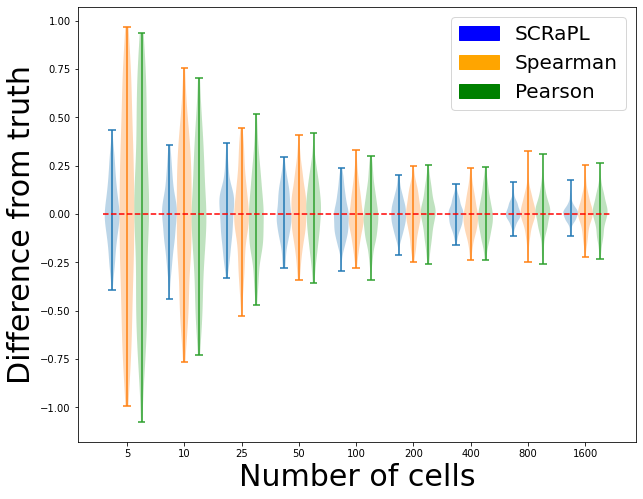

In [5]:
plt.rcParams["figure.figsize"] = (10,8)
plt.violinplot(cor_scrapl_col,positions=lb_cor_scrapl_tick, widths=16.5)
plt.xticks(lb_cor_spr_tick,lb_cor)
plt.violinplot(cor_spr_col,positions=lb_cor_spr_tick, widths=16.5)
plt.xticks(lb_cor_spr_tick,lb_cor)
plt.violinplot(cor_prs_col,positions=lb_cor_prs_tick, widths=16.5)
plt.xticks(lb_cor_spr_tick,lb_cor)

SCRaPL_patch = mpatches.Patch(color='blue', label='SCRaPL')
Spearman_patch = mpatches.Patch(color='orange', label='Spearman')
Pearson_patch = mpatches.Patch(color='green', label='Pearson')

plt.legend(handles=[SCRaPL_patch,Spearman_patch,Pearson_patch ],fontsize =20)
plt.hlines(y=0,xmin=-26.5,xmax=540.0,colors='r',linestyles='dashed')
plt.ylabel("Difference from truth",fontsize=30)
plt.xlabel("Number of cells",fontsize=30)
plt.savefig(Folder+'SCRaPL/Synth/Extra_Synth_violin_1.pdf', bbox_inches='tight')
plt.show()


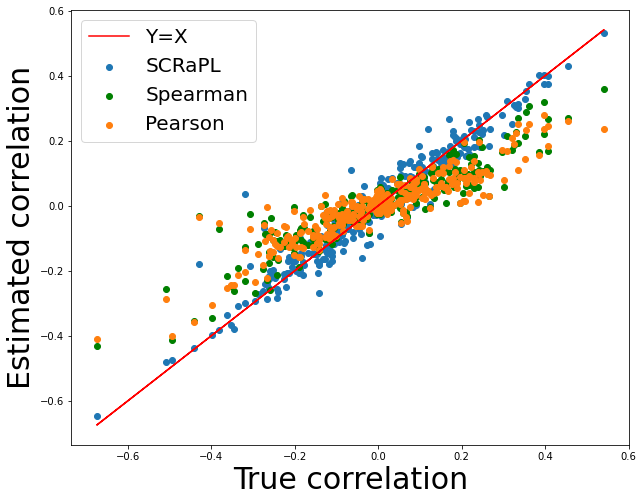

In [6]:
plt.plot(true_cor,true_cor,color='red')
plt.scatter(true_cor,cor_scrapl)
plt.scatter(true_cor,cor_spr,color='green')
plt.scatter(true_cor,cor_prs)
plt.xlabel("True correlation",fontsize =30)
plt.ylabel("Estimated correlation",fontsize =30)
plt.legend(["Y=X","SCRaPL","Spearman","Pearson"],fontsize =20)
#plt.savefig(Folder+'SCRaPL/Synth/Synth_violin1.pdf', bbox_inches='tight')
plt.show()